In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import sys
import os
from pathlib import Path

from nilearn.plotting import plot_connectome

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)
    
from dn_utils.plotting import aligned_imshow_cbar
%matplotlib inline

/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code/dn_utils/glm_utils.py:13: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats import design_matrix


In [2]:
def distance(r1, r2):
    '''Euclidean distance between two points in 3D space.'''
    return math.sqrt(sum(c ** 2 for c in (c1 - c2 for c1, c2 in zip(r1, r2)))) 

def sphere_radius(volume):
    '''Radius of sphere with specified volume.'''
    return (volume * (3 / 4) / math.pi) ** (1 / 3)

In [3]:
path_derivatives = os.path.join(path_root, 'data/main_fmri_study/derivatives')
path_custom_roi = os.path.join(path_derivatives, 'ppi/parcellations/custom_roi')
path_nistats_results = os.path.join(path_derivatives, 'nistats/results')
path_clusters_perr = os.path.join(
    path_nistats_results,
    'clusters_perr_aggregated_manually_labeled.csv')

Path(path_custom_roi).mkdir(parents=True, exist_ok=True)

### Load activation analysis clusters

In [4]:
df = pd.read_csv(path_clusters_perr)
df = df[['Regions', 'Hemisphere', 'X', 'Y', 'Z', 
         'Peak Stat', 'Cluster Size (mm3)']]

# Split into separate DataFrames for each contrast
row_inc = (df['Regions'] == 'perr_inc_alpha_0_0001').idxmax()
row_dec = (df['Regions'] == 'perr_dec_alpha_0_0001').idxmax()
row_diff = (df['Regions'] == 'perr_rew_minus_pun_alpha_0_001').idxmax()
df_inc_dd = df[row_inc+1:row_dec].copy()
df_dec_dd = df[row_dec+1:row_diff].copy()

### Decreasing prediction error
ROIs are created as spherese around voxels selected as:
- five cluster peaks with highest z-score from activation-analysis (`perr_dec` contrast)
- all cluster peaks from meta-analysis (NEG > POS pattern) with ALE score > 0.035

If data-driven ROIs anatomically overlap with meta-analytic ROIs, we select former. 

In [5]:
ale_clusters_dec_data = [
    ['Inferior parietal lobule', 'R', 40, -48, 42, 0.039, 2416],
    ['Inferior parietal lobule', 'L', -38, -48, 42, 0.043, 2216],
]

ale_clusters_dec_dicts = [
    {k: v for k, v in zip(df_dec_dd.columns, cluster_data)} 
    for cluster_data in ale_clusters_dec_data]

# Metaanalytic decreasing PE ROIs
df_dec_meta = pd.DataFrame(ale_clusters_dec_dicts)
df_dec_meta['origin'] = 'meta-analysis'

# Data-driven decreasing PE ROIs
df_dec_dd = df_dec_dd.loc[df_dec_dd['Regions'].notna()].iloc[:5]
df_dec_dd['origin'] = 'data-driven'

# Concat meta-analytic ROIs and data-driven ROIs
df_dec = pd.concat([df_dec_dd, df_dec_meta])
df_dec.reset_index(inplace=True, drop=True)
df_dec['netName'] = 'perr_dec'

### Increasing prediction error
ROIs are created as spherese around voxels selected as:
- five cluster peaks with highest z-score from activation-analysis (`perr_inc` contrast)
- all cluster peaks from meta-analysis (POS > NEG pattern) with ALE score > 0.035

If data-driven ROIs anatomically overlap with meta-analytic ROIs, we select former.

In [6]:
ale_clusters_inc_data = [
    ['Ventral striatum', 'L', -12, 8, -4, 0.052, 4880],
    ['Ventral striatum', 'R', 8, 8, -2, 0.038, 2880],
]

ale_clusters_inc_dicts = [
    {k: v for k, v in zip(df_inc_dd.columns, cluster_data)} 
    for cluster_data in ale_clusters_inc_data]

# Metaanalytic increasing PE ROIs
df_inc_meta = pd.DataFrame(ale_clusters_inc_dicts)
df_inc_meta['origin'] = 'meta-analysis'

# Data-driven increasing PE ROIs
df_inc_dd = df_inc_dd.loc[df_inc_dd['Regions'].notna()].iloc[:5]
df_inc_dd['origin'] = 'data-driven'

# Concat meta-analytic ROIs and data-driven ROIs
df_inc = pd.concat([df_inc_dd, df_inc_meta])
df_inc.reset_index(inplace=True, drop=True)
df_inc['netName'] = 'perr_inc'

In [7]:
# Aggregate all ROIs
df_aggregated = pd.concat([df_inc, df_dec])
df_aggregated.reset_index(inplace=True, drop=True)
df_aggregated['approxRadius'] = df_aggregated['Cluster Size (mm3)'].map(
    sphere_radius)

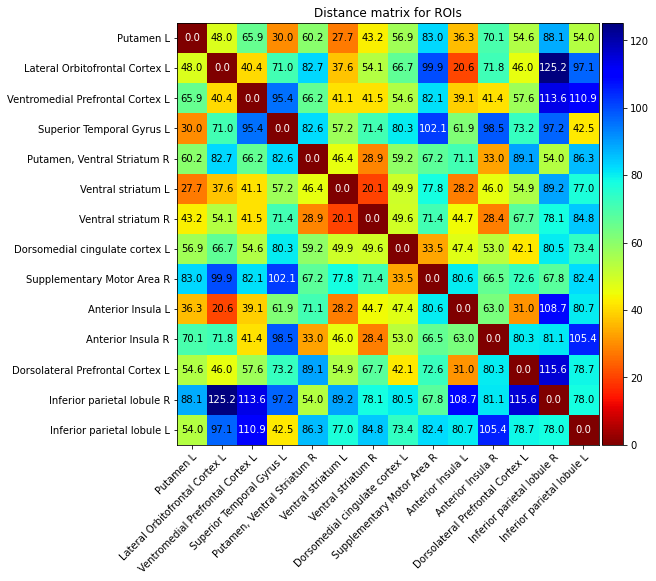

In [8]:
n_rois = len(df_aggregated)

distance_matrix = np.zeros((n_rois, n_rois))

for i in range(n_rois):
    for j in range(i, n_rois):
        distance_matrix[i, j] = distance(
            df_aggregated.loc[i, ['X', 'Y', 'Z']],
            df_aggregated.loc[j, ['X', 'Y', 'Z']]
        )
distance_matrix = distance_matrix + distance_matrix.T        
        
fig, ax = plt.subplots(figsize=(8, 8))
im = plt.imshow(distance_matrix, cmap='jet_r')
aligned_imshow_cbar(ax, im)

for i in range(n_rois):
    for j in range(n_rois):
        
        if distance_matrix[i, j] < 20 or distance_matrix[i, j] > 100:
            annotation_color = 'w'
        else:
            annotation_color = 'k'
            
        text = ax.text(j, i, f'{distance_matrix[i, j]:2.1f}', 
                       ha='center', va='center', color=annotation_color)
        
ax.set_xticks(np.arange(n_rois))
ax.set_yticks(np.arange(n_rois))
ax.set_yticklabels(df_aggregated['Regions'] + ' ' + df_aggregated['Hemisphere'])
ax.set_xticklabels(df_aggregated['Regions'] + ' ' + df_aggregated['Hemisphere'])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_title('Distance matrix for ROIs')
plt.show()

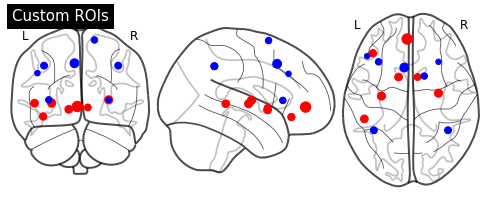

In [9]:
adjacency_matrix = np.zeros((n_rois, n_rois))
node_coords = np.array(df_aggregated.loc[:, ['X', 'Y', 'Z']])
node_color = df_aggregated['netName'].map(lambda net: 'blue' 
                                          if net == 'perr_dec' else 'red')
node_size = df_aggregated['approxRadius'].map(lambda size: int(size) * 6)

plot_connectome(
    adjacency_matrix=adjacency_matrix,
    node_coords=node_coords,
    node_color=list(node_color), 
    node_size=node_size,
    title='Custom ROIs'
)
plt.show()

In [12]:
# Prepare "atlas" for signal extraction 
df_aggregated['radius(mm)'] = 4
df_aggregated.rename(columns={cut.upper(): cut for cut in 'xyz'}, inplace=True)

# Save custom atlas
df_aggregated.to_csv(os.path.join(path_custom_roi, 'custom_roi_table.csv'), 
                     sep=' ', index=False)